# TDT4173 Machine Learning: Moscow project 

19/11 - 2021 \
Group 18 \
566618 Melissa Ulsøe Jessen \
566527 Elisa Duz \
566770 Eva Ophelie Marie Etheve

## Introduction

In this challenge we will predict the prices of apartments in Moscow. 

The dataset consists of information of over 33,000 apartments in Moscow. It contains around 30 variables that encode data such as location, facilities, and building information. The project is structured in the following way:

- In part 1 we do an exploratory data analysis (EDA) of the data. In the analysis we will (among other things) discover the relationship between each feature and the target variable, which is the price. We will also find and plot the correlation between each feature, which we use later.
- Based on the analysis we clean the data and fill out the missing values.
- With the clean and whole dataset we make new features based on the analysis and select which features we will use.
- In part 2 we implement and test different models, to find the mix of models that gives us the best predictions.
- Finally we make the predictions and submit the predictions on kaggle.

The project will in some way rely on previous knowledge. For example we have the hypothesis that the bigger an apartment is, the higher is the price. We also think that the location has a lot to say about the price. These hypotheses will be investigated in the EDA, where we also expect to discover more relations between the features and the price.

# Import librariers and load the datasets

In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns 
import sklearn.model_selection as model_selection
import sklearn.tree as tree
import math
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNetCV, LassoCV 
from math import ceil, sqrt as root
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
!pip install category_encoders
import category_encoders as ce 

In [2]:
apartments = pd.read_csv('data/apartments_train.csv')
buildings = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')

#Data (Combination of apartments_train and buildings_train) 
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

#Data_test (Same but with the test datasets)
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

#Data_train_valid
#data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())

all_data = pd.concat([data, data_test], ignore_index=True)
target = np.log(data.price)
N_train = np.shape(data)[0]
N_test = np.shape(data_test)[0]

# Part.1 : Exploratory Data Analysis (EDA)

## 1.1 Overview of the features

First we will have an overview of the data.

### Describe the datasets

In [3]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 
    

In [4]:
apartments = pd.read_csv('data/apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)

describe_data(apartments, apartments_meta)

Loaded 23285 apartments


Here we get a quick overview of the data. We see that many of the values seems correct, for example is the mean of area_total 74.5 $\text{m}^2$, which seems believable. Conversely we also see that some of the values seems to contain an error, for example is the maximum value of the ceiling 340 m. We believe that this is an error and that the ceiling is meant to be 340 cm = 3.4 m. This is a problem we will handle in the section 1.3 Cleaning the data. We also see that some features contains many missing values. This will be handled in 1.4 Missing values.

In [5]:
buildings = pd.read_csv('data/buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('data/buildings_meta.json') as f: 
    buildings_meta = json.load(f)

describe_data(buildings, buildings_meta)

Loaded 6791 buildings


In [6]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')

#Overview of the data
print("There are", data.shape[0], "instances of training data")
print("There are", data_test.shape[0], "instances of test data")
print("Total number of features equals", data.shape[1])

All apartments have an associated building: True
There are 23285 instances of training data
There are 9937 instances of test data
Total number of features equals 34


Note that even some features are described as numerical type, they can be a categorical feature. Then after analysing the above description of the data, we can divide the features into 3 groups: 

- The **16** categorical variables are : `seller`, `layout`, `windows_court`,`windows_street`, `condition`, `new`, `district`, `material`, `street`, `address`, `elevator_without`, `elevator_passenger`, `elevator_service`, `parking`, `garbage_chute`, `heating`. 
- The **15** numerical variables are : `area_total`, `area_kitchen`, `area_living`, `floor`, `rooms`, `ceiling`, `bathrooms_shared`, `bathrooms_private`, `balconies`, `loggias`, `phones`, `latitude`, `longitude`, `constructed`, `stories`.
- The target feature `price`. The features `id`, `building_id` can be dropped.

There is lots of information that is probably related to the target feature `price` like the area, the geographical situation, the neighborhood (district) and so on. We will see which features are the most important and which ones we can leave out. 

In [7]:
data.describe()

id        seller         price    area_total  area_kitchen  \
count  23285.000000  14455.000000  2.328500e+04  23285.000000  18564.000000   
mean   11642.000000      1.875683  2.355617e+07     74.450999     12.552279   
std     6721.944845      1.089518  5.264393e+07     58.671373      6.565686   
min        0.000000      0.000000  9.000000e+05      9.300000      1.000000   
25%     5821.000000      1.000000  7.490000e+06     42.000000      8.200000   
50%    11642.000000      2.000000  1.064500e+07     59.800000     10.700000   
75%    17463.000000      3.000000  2.050000e+07     84.800000     15.300000   
max    23284.000000      3.000000  2.600000e+09   2181.000000    100.000000   

        area_living         floor         rooms       layout       ceiling  \
count  19403.000000  23285.000000  23285.000000  5643.000000  12192.000000   
mean      38.741367      8.969594      2.189349     1.039695      3.268374   
std       31.398480      8.322039      1.076130     0.351507     10.802728   
min        0.000000      1.000000      1.000000     0.000000      0.000000   
25%       20.000000      3.000000      1.000000     1.000000      2.650000   
50%       30.900000      7.000000      2.000000     1.000000      2.800000   
75%       45.300000     12.000000      3.000000     1.000000      3.000000   
max      900.000000     95.000000      6.000000     2.000000    340.000000   

       ...      district   constructed      material       stories  \
count  ...  23155.000000  22491.000000  19313.000000  23285.000000   
mean   ...      4.654848   2002.729581      2.203956     17.608933   
std    ...      3.155835     22.948365      1.021101     11.216638   
min    ...      0.000000   1855.000000      0.000000      1.000000   
25%    ...      2.000000   1989.000000      2.000000      9.000000   
50%    ...      5.000000   2013.000000      2.000000     16.000000   
75%    ...      7.000000   2020.000000      3.000000     22.000000   
max    ...     11.000000   2023.000000      6.000000     95.000000   

       elevator_without  elevator_passenger  elevator_service       parking  \
count      22928.000000        22928.000000      22928.000000  16497.000000   
mean           0.392620            0.929867          0.743109      0.572589   
std            0.488344            0.255376          0.436928      0.549630   
min            0.000000            0.000000          0.000000      0.000000   
25%            0.000000            1.000000          0.000000      0.000000   
50%            0.000000            1.000000          1.000000      1.000000   
75%            1.000000            1.000000          1.000000      1.000000   
max            1.000000            1.000000          1.000000      2.000000   

       garbage_chute       heating  
count   14474.000000  15124.000000  
mean        0.806411      0.176012  
std         0.395124      0.566275  
min         0.000000      0.000000  
25%         1.000000      0.000000  
50%         1.000000      0.000000  
75%         1.000000      0.000000  
max         1.000000      3.000000  

[8 rows x 32 columns]

Let's see what can we infer from the above describe function. 

- Look at  the `area_total`, `area_kitchen`, `area_living` columns for instance. The dataset has houses with a total area of 2181, kitchen area of 100 and living area of 900 which seems to be huge. So it would be interesting to know more about this as we progress. For example if it is the same house and then consider it as an outlier. 

Lastly we will find out how many duplicates the data contains.

In [8]:
data2 = data.drop("id", axis=1)
data_test2 = data_test.drop("id", axis=1)

nb_duplicata_train = len(data2[data2.duplicated()]) 
nb_duplicata_test = len(data_test2[data_test2.duplicated()]) 

print("Number of duplicate values in the training dataset : ", nb_duplicata_train)
print("Number of duplicate values in the test dataset : ", nb_duplicata_test)

Number of duplicate values in the training dataset :  465
Number of duplicate values in the test dataset :  238


Later we will leave this duplicates out so that they will not carry more weight than others. 

### The target variable : Distribution of `Price`

Text(0.5, 1.0, 'Distribution of prices after log transform')

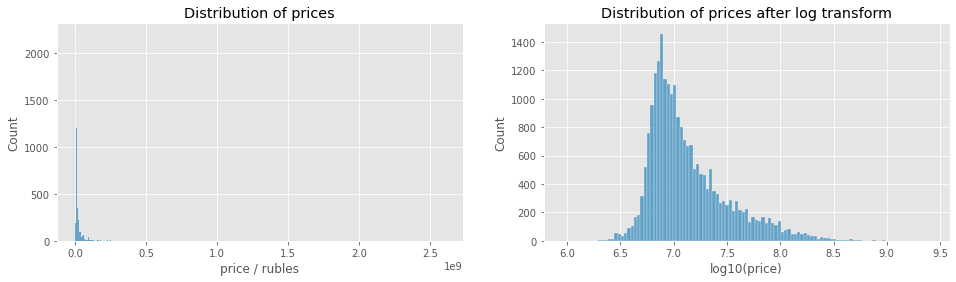

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 4))
sns.histplot(data.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of prices')
sns.histplot(np.log10(data.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of prices after log transform')

On this graph, we can see that the price distribution is highly skewed to the right accroding to the value of the skewness $1.25$ which is consistent with the description of the characteristics seen above : the minimum and maximum of the house prices are respectively $900,000$ and $26,000,000,000$. Furthermore, the majority of the house prices are between $7,490,000$ and $20,500,000$. So, the prices are widely distributed. Then the target variable `price` is not normally distributed. This can reduce the performance of some ML regression models because some assume normal distribution. Thus, let's make a log transformation. 

## Individual features - Univariate Analysis

Before starting the univariate analysis, we first define the lists of numerical and categorical features for the next plots. 

In [11]:
#Categorical 
categorical = ['seller', 'layout', 'windows_court', 'windows_street', 'condition', 'new', 'district', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']

#Numerical 
numerical = list(data.select_dtypes(include = 'number'))
for feature in categorical :
    if feature in numerical :
        numerical.remove(feature)
        
#We remove these features for the next plots
numerical.remove('id')
numerical.remove('building_id')
numerical.remove('price')

Note that we dropped `street` and `address` because it will be easier for the next plots. 

#### a) Numerical variables

First of all, we can plot an overview of the distribution of the numerical features. 

Skewness of area_total  :  8.610355337313235
Kurtosis of area_total  :  211.6232571614912
Skewness of area_kitchen  :  2.2075712888268324
Kurtosis of area_kitchen  :  10.277686790086221
Skewness of area_living  :  5.319535893430051
Kurtosis of area_living  :  69.52798262080236
Skewness of floor  :  2.7906006853159786
Kurtosis of floor  :  13.927755824051527
Skewness of rooms  :  0.80435752892829
Kurtosis of rooms  :  0.5090196248931202
Skewness of ceiling  :  26.901549577523177
Kurtosis of ceiling  :  730.3538951499254
Skewness of bathrooms_shared  :  0.9900769911152517
Kurtosis of bathrooms_shared  :  1.070187396274541
Skewness of bathrooms_private  :  0.9706630088786651
Kurtosis of bathrooms_private  :  1.142169368824959
Skewness of balconies  :  0.9345732389396081
Kurtosis of balconies  :  0.8826315526679913
Skewness of loggias  :  0.857511166859135
Kurtosis of loggias  :  1.4470496930004235
Skewness of phones  :  0.5908878681938566
Kurtosis of phones  :  0.7820509996183302
Skewness

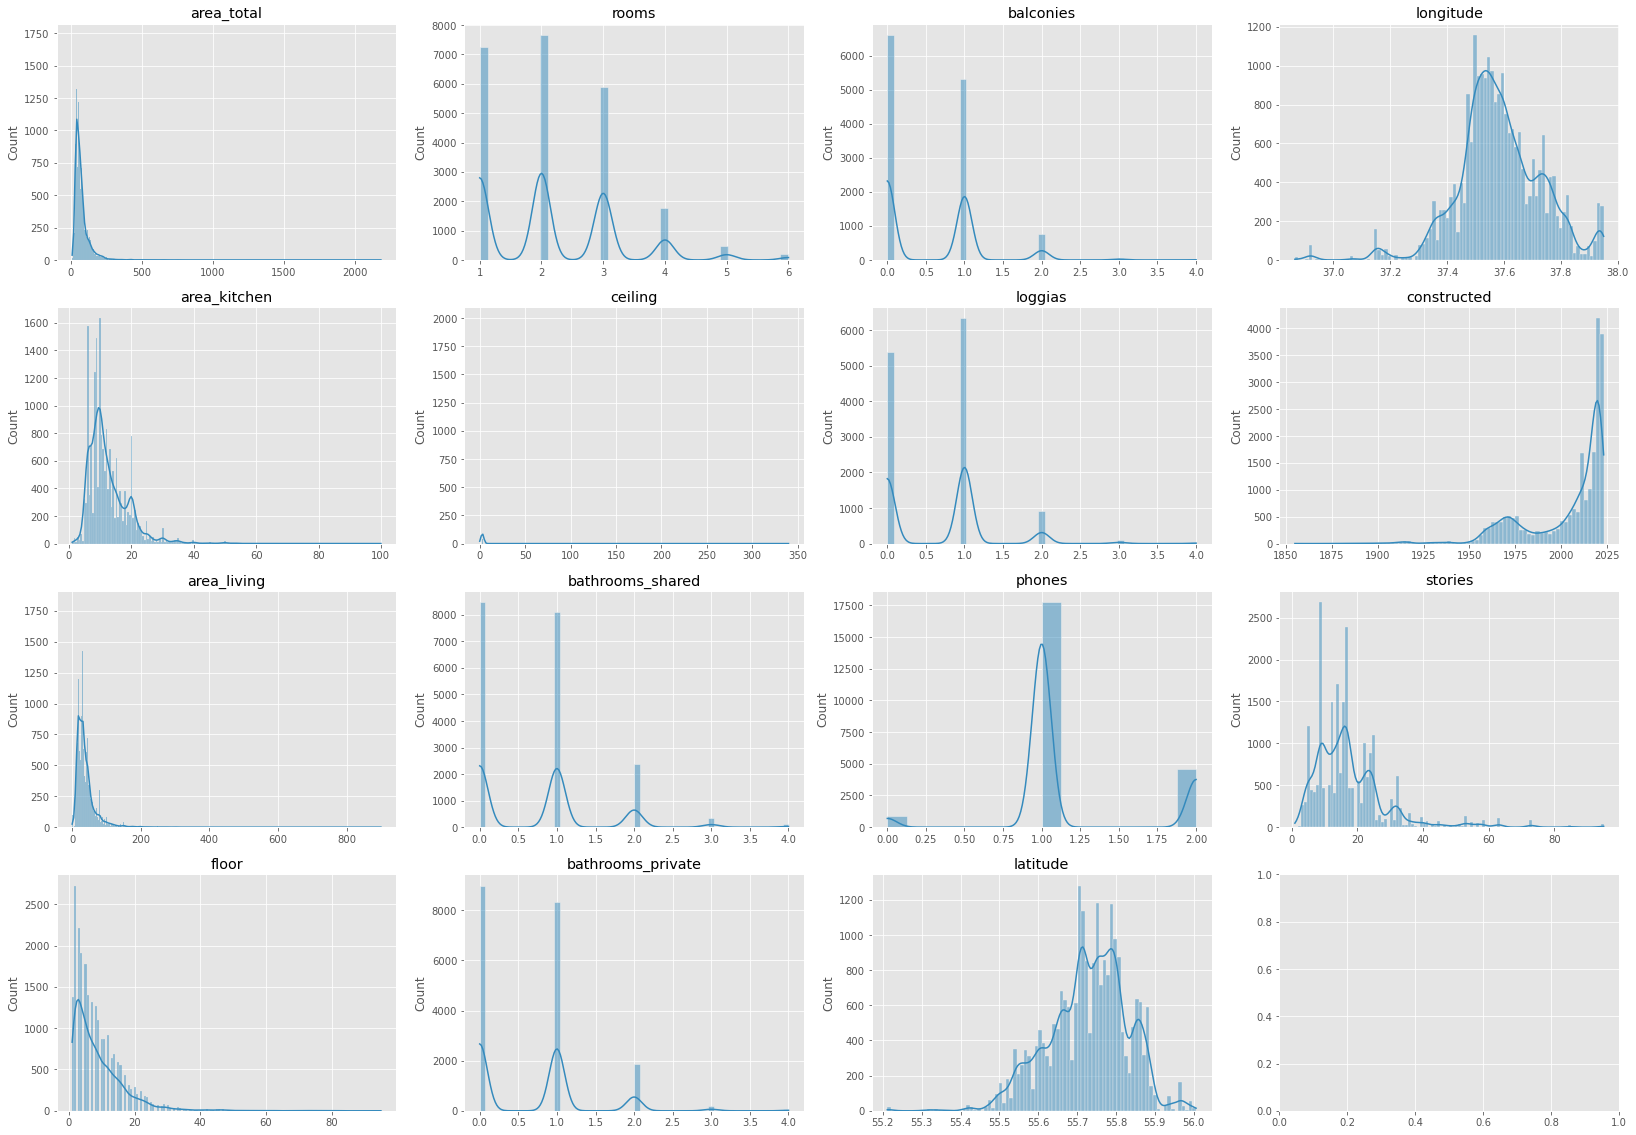

In [12]:
a,b = 4,4
fig, axes = plt.subplots(a,b,figsize=(28, 20))
j,k = 0,0
count = 0

for i in numerical:
    
    sns.histplot(data[i],kde=True,ax=axes[j,k]).set(title=i,xlabel=None)
    
    print("Skewness of", i, " : ", data[i].skew())
    print("Kurtosis of", i, " : ",data[i].kurtosis())

    if count == 3:
        j = 0
        k = 1

    elif count == 7:
        j = 0
        k = 2
    
    elif count == 11:
        j = 0
        k = 3
    
    else:
        j = j + 1

    count += 1


We see that some of the feature values are not normally distributed (for example `area_total` and `area_kitchen`). Then it can be better to use the log function. \
Consider the figure below where the log of `area_total` is plotted.

C:\Users\evaet\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


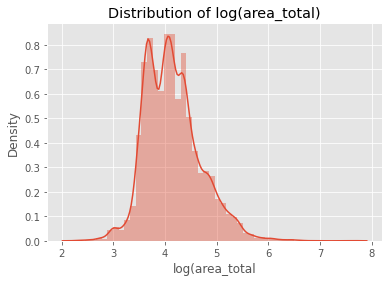

Skewness of the log(area_total) :  0.6619292840715439
Kurtosis of the log(area_total) :  1.0066093788056367


In [13]:
sns.distplot(np.log(data.area_total)) 
plt.title("Distribution of log(area_total)")
plt.xlabel("log(area_total")
plt.show()

print("Skewness of the log(area_total) : ", (np.log(data.area_total)).skew())
print("Kurtosis of the log(area_total) : ", (np.log(data.area_total)).kurtosis())

We see that the log of `area_total` is closer to a normal distribution than `area_total` itself.

#### b) Categorical variables

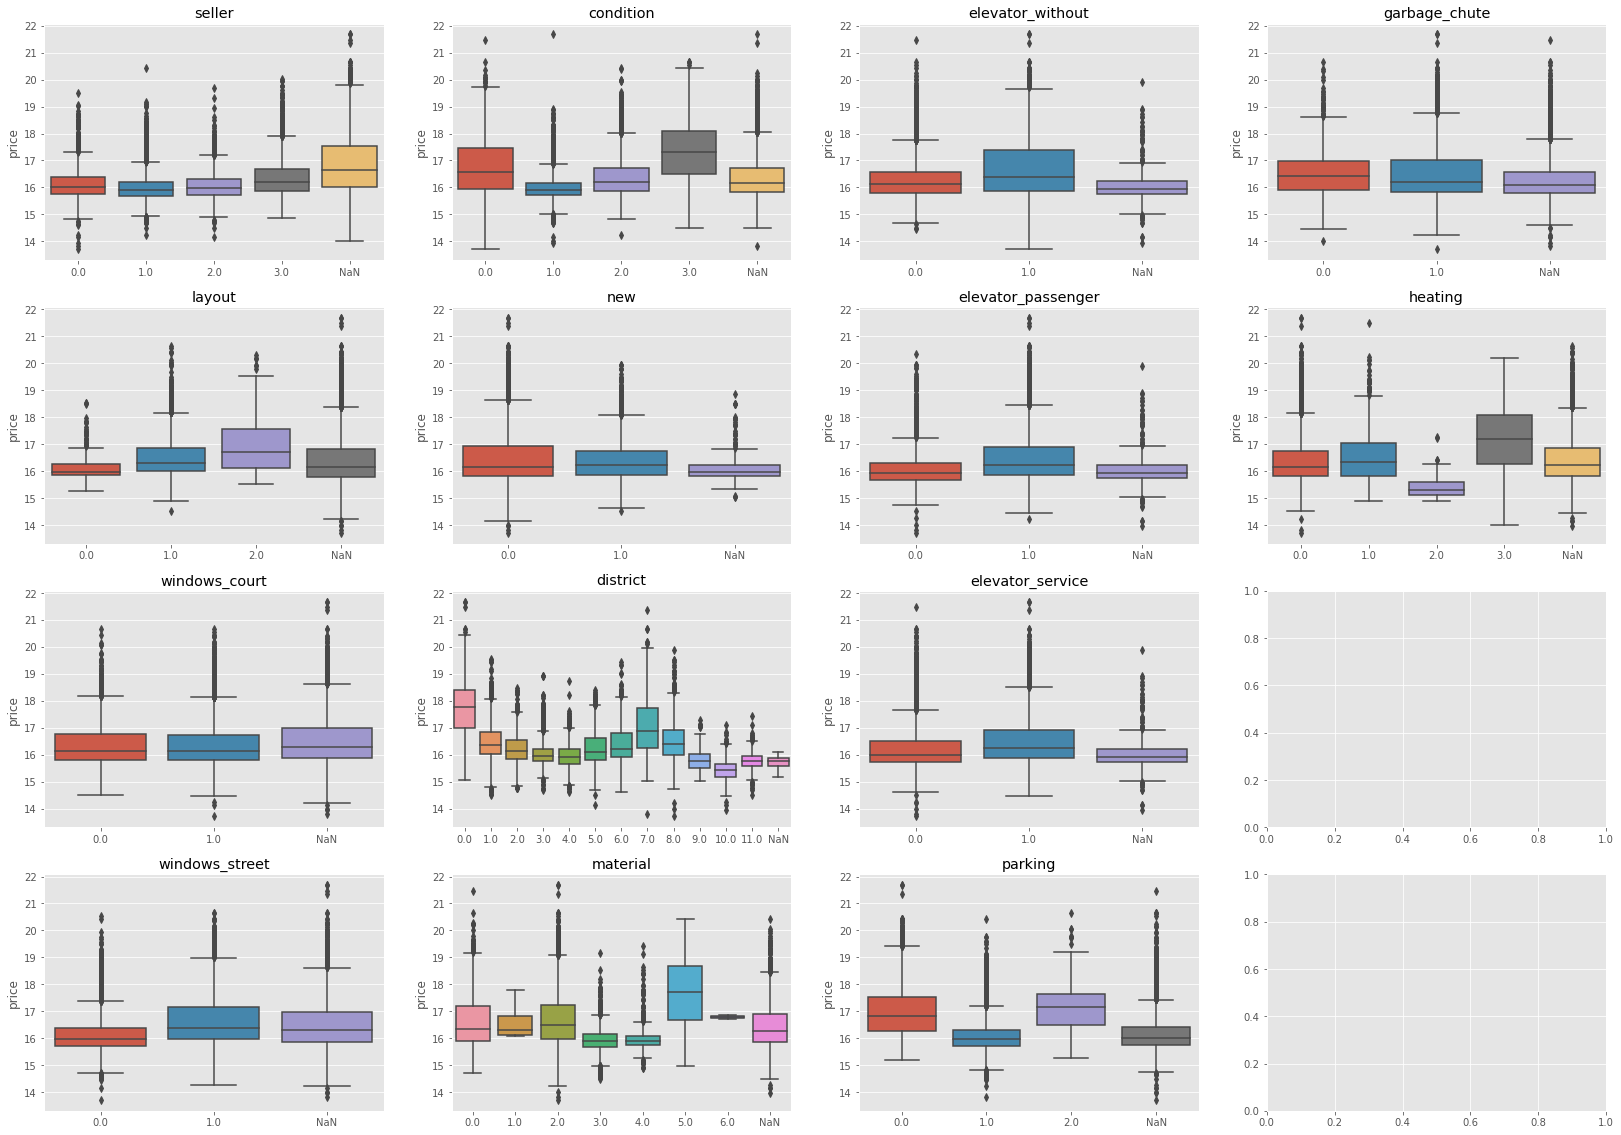

In [14]:
data2 = data.copy()

a,b = 4,4
fig, axes = plt.subplots(a,b,figsize=(28, 20))
j,k = 0,0
count = 0

for feat in categorical :
    data2[feat] = data2[feat].astype('category')
    if data2[feat].isna().any():
        data2[feat] = data2[feat].cat.add_categories(['NaN'])
        data2[feat] = data2[feat].fillna('NaN')

    sns.boxplot(x=data2[feat], y=np.log(data2.price),ax=axes[j,k]).set(xlabel=None,title=feat)

    if count == 3:
        j = 0
        k = 1

    elif count == 7:
        j = 0
        k = 2
    
    elif count == 11:
        j = 0
        k = 3
    
    else:
        j = j + 1

    count += 1

Then, we can see that house prices are more sensitive to certain categories than others. For example, the `layout`, `condition`, `district` (which makes sense because it is well known that living in a certain area can be more expensive than another. At first sight, living in districts 0 (the Center) and 7 (South East) seems more expensive), `material` (apart from category 5 corresponding to "stalin_project" with only 2 houses, overall, block and monolith buildings are the most expensive), `parking` and also `heating` (there is a big difference in price between 2-central heating and 3-individual heating. The cheapest houses are those with central heating). 

One thing that may seem surprising in this dataset is that the newness of the house does not seem to greatly affect its price. 

## 1.2 Relation of all features to target price

We will now consider how the features are related to the target. We will consider both the Pearson correlation and the Spearman correlation.

### a) Pearson correlation measure 
In order to predict the sale price, it is important to identify the most important features i.e those that will most influence the price of the property. One way to identify the is to use the correlation table using the Pearson correlation measure. The coefficient is equal to **1** when one variable is an increasing affine function of the other variable, and respectively to **-1** when this function is decreasing.
We will consider here a strong correlation when the absolute value of the coefficient is higher than 0.4.


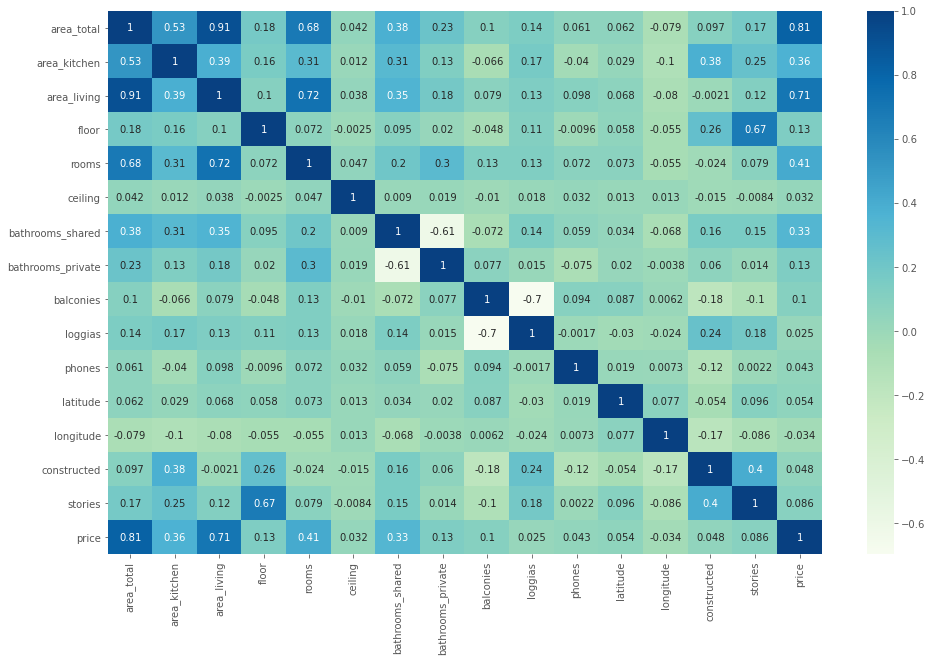

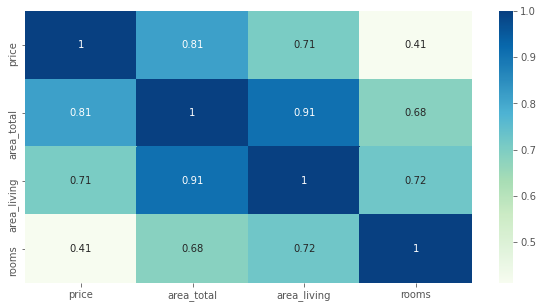

In [15]:
numerical.append('price')
#MAP 1 : All coefficients with price
f, ax = plt.subplots(figsize=(16, 10)) 
sns.heatmap(data[numerical].corr(), cmap = "GnBu", annot=True)

#MAP 2 : Selection of the most important features with threshold = 0.4
threshold = 0.4
corr_matrix = data.corr()
most_corr_feat = corr_matrix.index[abs(corr_matrix["price"])>threshold]
#most_corr_feat = corr_matrix.index[abs(corr_matrix["log_price"])>threshold]
plt.figure(figsize=(10,5))
g = sns.heatmap(data[most_corr_feat].corr(), cmap = "GnBu", annot=True)

**Observations from the heatmap :** 

In the first graph we can see that there are many features that seem to have little or no correlation with the sales price. Thus, we have selected only those whose absolute value of the coefficient is higher than 0.4. 

We mainly find space-related features such as `area_total`, `area_living`, `rooms`... which are all positively correlated with the selling price. As one would expect, the logic being that larger properties should be more expensive. 

### b) Spearman correlation measure 

However, the problem with the Pearson measure is that we are only looking at linearly correlated features when they may be correlated but not linearly. That's why we can also consider the Spearman measure which describes how well the relationship between two variables can be described using a monotonic function.

<AxesSubplot:xlabel='spearman', ylabel='feature'>

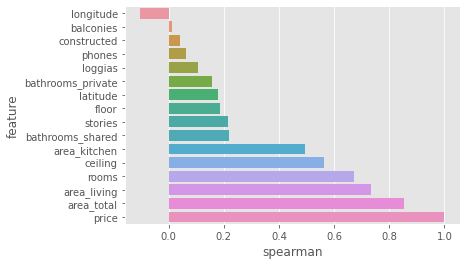

In [16]:
features = numerical + categorical 
spr = pd.DataFrame()
spr['feature'] = numerical
spr['spearman'] = [data[f].corr(data['price'], 'spearman') for f in numerical]
spr = spr.sort_values('spearman')
plt.figure(figsize=(6, 0.25*len(numerical)))    
sns.barplot(data=spr, y='feature', x='spearman', orient='h')

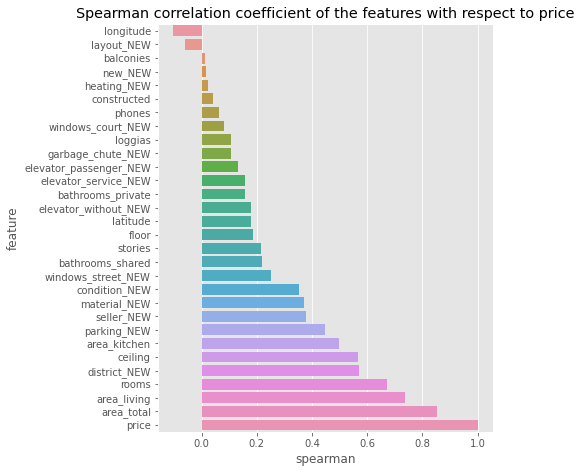

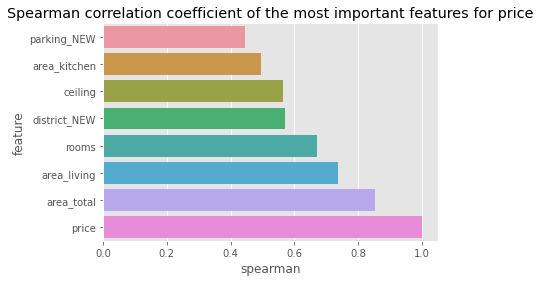

In [17]:
#Calculation of the spearman coefficient for the categorical features

def prepare(data, feature):
    sort = pd.DataFrame()
    sort['val'] = data[feature].unique()
    sort.index = sort.val
    sort['spmean'] = data[[feature, 'price']].groupby(feature).mean()['price']
    sort = sort.sort_values('spmean')
    sort['sorted'] = range(1, sort.shape[0]+1)
    sort = sort['sorted'].to_dict()
    
    for category, new_index in sort.items():
        data.loc[data[feature] == category, feature+'_NEW'] = new_index

feat_prepared = []
for category in categorical:  
    prepare(data2, category)
    feat_prepared.append(category + '_NEW')

#method='kendall' --> less sensitive to outliers
    
def spearman(frame, features):
    coef = pd.DataFrame()
    coef['feature'] = features
    coef['spearman'] = [frame[f].corr(frame['price'], 'spearman') for f in features]
    coef = coef.sort_values('spearman')
    most_coef = coef[abs(coef['spearman'])>threshold]
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=coef, y='feature', x='spearman', orient='h') 
    plt.title('Spearman correlation coefficient of the features with respect to price')
    plt.show()
    sns.barplot(data=most_coef, y='feature', x='spearman', orient='h')
    plt.title('Spearman correlation coefficient of the most important features for price')
    plt.show()
    
features = numerical + feat_prepared
spearman(data2, features)

As we have seen before, `area_total` always has a strong correlation with price. Thanks to the Spearman coefficient we can also see that `ceiling`, `district`, `parking` play a role in the variation of the house price. This was to be expected as it is well known that some neighbourhoods are more expensive than others for example. 

However, one thing that seems suspicious here is that we do not find the features related to the location of the house i.e latitude and longitude), which has a huge influence on the price of a house. Indeed, it is well known that the more you live in the city centre, the higher is the price of the property. This problem will be handled in the feature engineering part.

## Bivariate analysis

Now that we know some of the most important features, we can plot graphs to see their relationship with price.

C:\Users\evaet\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Parking')

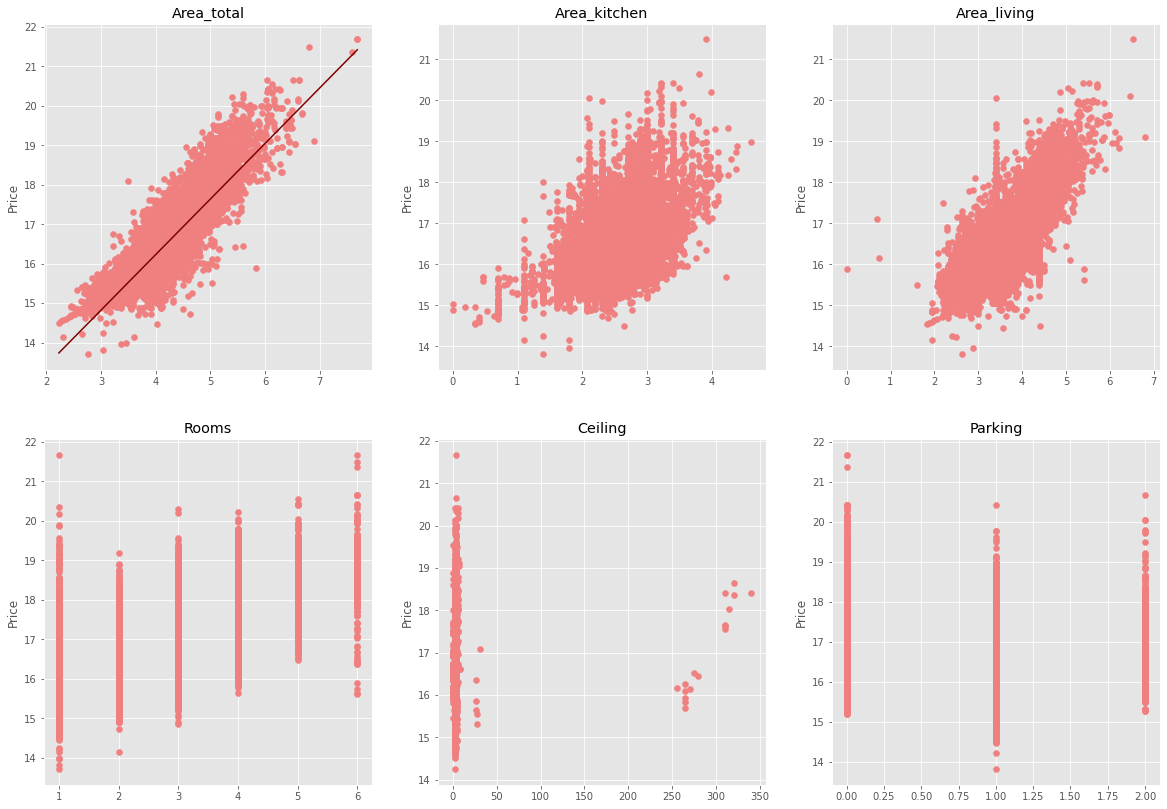

In [18]:
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2,3,figsize=(20,14))

j,k=0,0
x=np.log(data.area_total)
y=np.log(data.price)
axes[j,k].scatter(x=np.log(data.area_total),y = np.log(data.price), color="lightcoral")
axes[j,k].set_title("Area_total")
axes[j,k].set_ylabel("Price")
axes[j,k].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='maroon')

j,k=0,1
axes[j,k].scatter(x= np.log(data.area_kitchen),y = np.log(data.price), color="lightcoral")
axes[j,k].set_title("Area_kitchen")
axes[j,k].set_ylabel("Price")

j,k=0,2
axes[j,k].scatter(x= np.log(data.area_living),y = np.log(data.price),color="lightcoral")
axes[j,k].set_title("Area_living")
axes[j,k].set_ylabel("Price")

j,k=1,0
x=np.log(data.rooms)
y=np.log(data.price)
axes[j,k].scatter(x=data.rooms,y = np.log(data.price), color="lightcoral")
axes[j,k].set_ylabel("Price")
axes[j,k].set_title("Rooms")

j,k=1,1
axes[j,k].scatter(x=data.ceiling,y = np.log(data.price), color="lightcoral")
axes[j,k].set_ylabel("Price")
axes[j,k].set_title("Ceiling")

j,k=1,2
axes[j,k].scatter(x=data.parking,y = np.log(data.price), color="lightcoral")
axes[j,k].set_ylabel("Price")
axes[j,k].set_title("Parking")

## 1.3 Cleaning the data

From data.describe we have seen that `area_living` has a mean/median almost twice as small as that of `area_total`. So for flats with only 0, 1 or 2 m² living area it makes sense to replace them with the minimum of `area_total`/2.

We have also seen that for the ceiling there are some values that seems to contain an error, for example is the maximum value of 340m. To handle this we treat all the abnormal values.

Moreover, in the next part, when trying to find the missing district values, we will realise that some of the latitude and longitude values are wrong because some of the flats are outside Moscow and even outside Russia. The cleaning of these data will be done in the next part. 

In [19]:
#Area_living
all_data.loc[all_data['area_living']<(all_data.area_total.min())/2,'area_living'] = all_data.area_total.min()/2

#Ceiling 
all_data.loc[all_data['ceiling']>=250,'ceiling']=all_data['ceiling']/100
all_data.loc[all_data['ceiling']>=20,'ceiling']=all_data['ceiling']/10
all_data.loc[all_data['ceiling']==0.03,'ceiling']=all_data['ceiling']*100
all_data.loc[all_data['ceiling']==0,'ceiling']=all_data['ceiling'].mean()

## 1.4 Missing values 

<AxesSubplot:>

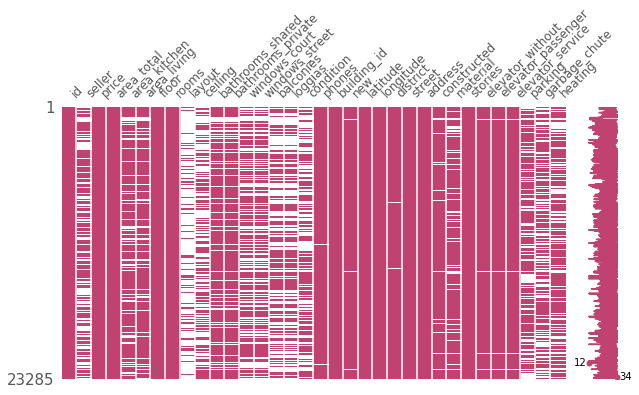

In [20]:
!pip install missingno
import missingno

missingno.matrix(data,figsize=(10,5), fontsize=12,color=(0.75, 0.26, 0.44))

We can see that the distribution of missing values for some features are really similar. That is the case for :
- `area_living` & `area_kitchen`
- `bathrooms_shared` & `bathrooms_private`
- `windows_court` & `windows_street`
- `balconies` & `loggias`

So it would be relevant to try a method which fills in the same way the missing values for these features. For example, when we impute the missing values for the numerical features, we used the same method for `area_living` and `area_kitchen` based on `area_total` since they are highly correlated. 

<AxesSubplot:>

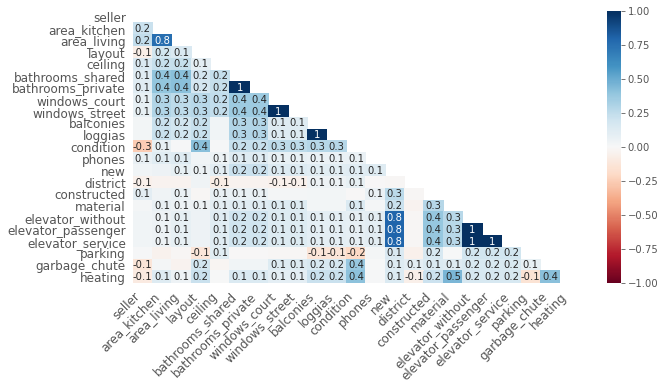

In [21]:
missingno.heatmap(data, figsize=(10,5), fontsize=12)

In the plot above, a positive correlation of 1 means that if the value of one feature is present, then the value of the other one also. A negative correlation of -1 means that if the value of one feature is present, then the value of the other is missing.

Here we can see that there is a strong positive correlation (0.8) between :
- `area_living` & `area_kitchen`
- `new` & (`elevator_without`, `elevator_passenger`, `elevator_service`)

Also there is a correlation of 1 between :
- `bathrooms_shared` & `bathrooms_private`
- `loggias` & `balconies`
- `windows_court` & `windows_street`
- all the features related to elevator

<AxesSubplot:>

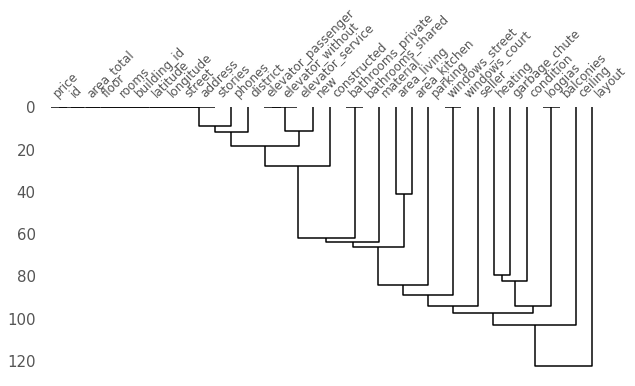

In [22]:
missingno.dendrogram(data, figsize=(10,5), fontsize=12)

The plot above shows clusters of features which have a similar distribution of missing values.
For example `price`, `id`, `area_total`, `floor`, `rooms`, `building_id`, `latitude`, `longitude`, `street`, `address` are in the same cluster because there are no missing values for these features. \
\
Filling the missing values can be done with several methods. In method 1 we calculate the missing values for `area_living` and `area_kitchen` based on the `area_total`, since the correlation is so high. The remaining missing values are replaced by the mean (or the median) of the specific feature. In method 2 we replace the missing values with the value -999. In this case method 2 seems to be the best, so that is the one we will use.

In [23]:
categorical = ['seller', 'layout', 'windows_court', 'windows_street', 'condition', 'new', 'district', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating', 'street', 'address']
numerical = list(all_data.drop(categorical, axis=1).columns)

#----------------------numerical values----------------------
#Useful functions
def calc_miss_val(feat,mean,feat_compare,mean_compare):
    for i in range(len(feat)):
        if pd.isna(feat[i]):
            feat[i] = (feat_compare[i]/mean_compare)*mean
    return feat

#There is only one building without lat/long so let's fill them since we have the address
all_data.latitude.fillna(55.56952, inplace=True) 
all_data.longitude.fillna(37.48932, inplace=True) 

imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
#imputer = SimpleImputer(missing_values=np.NaN, strategy='median')

"""
#Method 1 : mean over all the data
all_data.area_living = calc_miss_val(all_data.area_living,all_data.area_living.mean(),all_data.area_total,all_data.area_total.mean())
all_data.area_kitchen = calc_miss_val(all_data.area_kitchen, all_data.area_kitchen.mean(), all_data.area_total, all_data.area_total.mean())
all_data.bathrooms_shared = imputer.fit_transform(all_data['bathrooms_shared'].values.reshape(-1,1))[:,0]
all_data.bathrooms_private = imputer.fit_transform(all_data['bathrooms_private'].values.reshape(-1,1))[:,0]
all_data.ceiling = imputer.fit_transform(all_data['ceiling'].values.reshape(-1,1))[:,0]
all_data.balconies = imputer.fit_transform(all_data['balconies'].values.reshape(-1,1))[:,0]
all_data.loggias = imputer.fit_transform(all_data['loggias'].values.reshape(-1,1))[:,0]
all_data.phones = imputer.fit_transform(all_data['phones'].values.reshape(-1,1))[:,0]
all_data.constructed = imputer.fit_transform(all_data['constructed'].values.reshape(-1,1))[:,0]
"""

#Method 2 : try to input with the -999 
all_data.area_living.fillna(-999, inplace=True) 
all_data.area_kitchen.fillna(-999, inplace=True) 
all_data.bathrooms_shared.fillna(-999, inplace=True) 
all_data.bathrooms_private.fillna(-999, inplace=True) 
all_data.ceiling.fillna(-999, inplace=True) 
all_data.balconies.fillna(-999, inplace=True) 
all_data.loggias.fillna(-999, inplace=True) 
all_data.phones.fillna(-999, inplace=True) 
all_data.constructed.fillna(-999, inplace=True)

While trying to find the missing values of some districts, we realized that their latitude and longitude were in fact wrong. Indeed, some of the houses are very far away from Moscow (for example in the Carribean) and this cannot be true. So while filling in the missing values we also did some data cleaning and found the correct values for latitude and longitude based on the adress.

In [25]:
#Houses far away of Moscow
all_data.loc[(all_data.latitude==17.141734)&(all_data.longitude==-61.7905), "district"] = 11.0 #caribbean => Novomoskovsk
all_data.loc[(all_data.street=="Бунинские Луга ЖК")&(all_data.address=="к2/2/1"), "latitude"] = 55.5416739
all_data.loc[(all_data.street=="Бунинские Луга ЖК")&(all_data.address=="к2/2/1"), "longitude"] = 37.4856131
all_data.loc[(all_data.street=="Бунинские Луга ЖК")&(all_data.address=="к2/2/2"), "latitude"] = 55.5416739
all_data.loc[(all_data.street=="Бунинские Луга ЖК")&(all_data.address=="к2/2/2"), "longitude"] = 37.4856131

all_data.loc[(all_data.latitude==43.352968)&(all_data.longitude==132.759204), "district"] = 11.0 #next to china/japan 1 => Novomoskovsk
all_data.loc[(all_data.street=="улица Центральная")&(all_data.address=="48"), "latitude"] = 55.63298
all_data.loc[(all_data.street=="улица Центральная")&(all_data.address=="48"), "longitude"] = 37.4418942

all_data.loc[(all_data.latitude==43.353545)&(all_data.longitude==132.768097), "district"] = 11.0 #next to china/japan 2 => Novomoskovsk
all_data.loc[(all_data.street=="улица Центральная")&(all_data.address=="75"), "latitude"] = 55.5067389
all_data.loc[(all_data.street=="улица Центральная")&(all_data.address=="75"), "longitude"] = 37.2848903

all_data.loc[(all_data.latitude==42.9147)&(all_data.longitude==74.517184), "district"] = 3.0 #kirghizistan
all_data.loc[(all_data.street=="улица 1-я Линия")&(all_data.address=="57"), "latitude"] = 55.9270982
all_data.loc[(all_data.street=="улица 1-я Линия")&(all_data.address=="57"), "longitude"] = 37.5644065

all_data.loc[(all_data.latitude==55.932127)&(all_data.longitude==37.793705), "district"] = 3.0 #bit higher than Moscow
all_data.loc[(all_data.street=="В мкр")&(all_data.address=="30"), "latitude"] = 55.6510890
all_data.loc[(all_data.street=="В мкр")&(all_data.address=="30"), "longitude"] = 37.7034005

all_data.loc[(all_data.latitude==55.921627)&(all_data.longitude==37.781578), "district"] = 4.0 #bit higher than Moscow but looking at the address => South-East
all_data.loc[(all_data.street=="В мкр")&(all_data.address=="37"), "latitude"] = 55.605327
all_data.loc[(all_data.street=="В мкр")&(all_data.address=="37"), "longitude"] = 37.72449

#NaN 
all_data.loc[(all_data.latitude==55.59516)&(all_data.longitude==37.741109), "district"] = 5.0 #South 
all_data.loc[(all_data.latitude==55.56952)&(all_data.longitude==37.48932), "district"] = 11.0 #Novomoskovsk  
all_data.loc[(all_data.latitude==55.583551)&(all_data.longitude==37.711356), "district"] = 5.0 #South 
all_data.loc[(all_data.latitude==55.506739)&(all_data.longitude==37.28489), "district"] = 11.0 #South 

all_data.loc[(all_data.building_id==8811), "district"] = 11.0
all_data.loc[(all_data.building_id==8811), "district"] = 11.0

For the categorical features we input the missing values with the most frequent value of the specific feature (method 2). We have also tried method 1, where we create a new category, but it did not give a better result.

In [26]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

#----------------------categorical values----------------------
#Method 1 : create a new category where there are a lot of missing values
"""
data.parking.fillna(3.0, inplace=True) 
data_test.parking.fillna(3.0, inplace=True)
"""

#Method 2 : imputer with strategy 'most_frequent'
for feat in categorical : 
    all_data[feat] = imputer.fit_transform(all_data[feat].values.reshape(-1,1))[:,0]

In [28]:
#Check if we have no more missing values (except for prices for the future data_test) 
print(all_data.isna().sum())

id                       0
seller                   0
price                 9937
area_total               0
area_kitchen             0
area_living              0
floor                    0
rooms                    0
layout                   0
ceiling                  0
bathrooms_shared         0
bathrooms_private        0
windows_court            0
windows_street           0
balconies                0
loggias                  0
condition                0
phones                   0
building_id              0
new                      0
latitude                 0
longitude                0
district                 0
street                   0
address                  0
constructed              0
material                 0
stories                  0
elevator_without         0
elevator_passenger       0
elevator_service         0
parking                  0
garbage_chute            0
heating                  0
dtype: int64


## 1.5 Feature Engineering

#### 1- Add boolean features

We also noticed that sometimes `area_living` is larger than `area_total` or `floor` is larger than the total number of floors in the building. So instead of removing them, we provide additional information by calculating the ratio between the 2 pairs and then set the value to 1 if this ratio exceeds the value of 1 and 0 otherwise. 

In [29]:
# Area_ratio => spotlight the area_living higher than the area_total
all_data = all_data.assign(area_ratio =all_data.area_living/all_data.area_total)
all_data.area_ratio = np.where(all_data.area_ratio <=1, all_data.area_ratio, 1)
all_data.area_ratio = np.where(all_data.area_ratio == 1, all_data.area_ratio, 0)

# Floor_ratio => spotlight the floor higher than the nb of stories
all_data = all_data.assign(floor_ratio=all_data.floor/all_data.stories)
all_data.floor_ratio = np.where(all_data.floor_ratio <=1, all_data.floor_ratio, 1)
all_data.floor_ratio = np.where(all_data.floor_ratio == 1, all_data.floor_ratio, 0)

#### 2- Latitude/longitude --> distance_city 

As we have seen before, there is no particular link between house prices and longitudes/latitudes. However, the location of a house has a clear influence on the price of a house. Thus, we have added a new category, which rather than considering latitudes and longitudes, is more interested in the distance of the house from the city centre of Moscow (whose longitudes and latitudes are $37.6$ and $55.76$). Indeed, as we can see, the houses are organised in a circular way. Thus we make a sort of change between Cartesian and Polar coordinates.

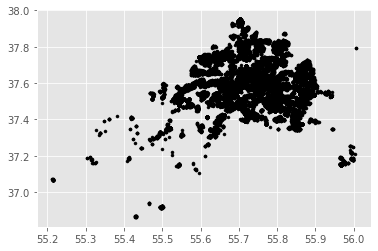

In [30]:
x = data['latitude']
y = data['longitude']
plt.scatter(x, y, marker = '.', color = 'black')

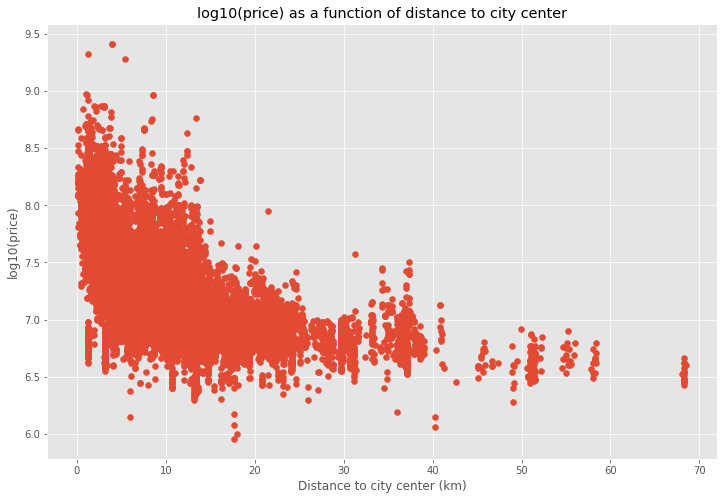

In [31]:
!pip install haversine
import haversine as hs 

def distance_city(loc1,loc2) :
    return hs.haversine(loc1,loc2)

moscow_center = [55.75, 37.6]
dist = []
for i in range(len(all_data)) :
    coord = [all_data.latitude[i], all_data.longitude[i]]
    dist.append(distance_city(moscow_center, coord))
    
all_data = all_data.assign(distance_city = dist)

p = all_data.distance_city[0:len(data)]
plt.figure(figsize = (12,8))
plt.scatter(p,np.log10(data.price))
plt.xlabel("Distance to city center (km)")
plt.ylabel("log10(price)")
plt.title("log10(price) as a function of distance to city center")
plt.show()

Now, if we look at the spearman coefficient with respect to the `price`, we can see that the location of the house is well correlated with its price. 

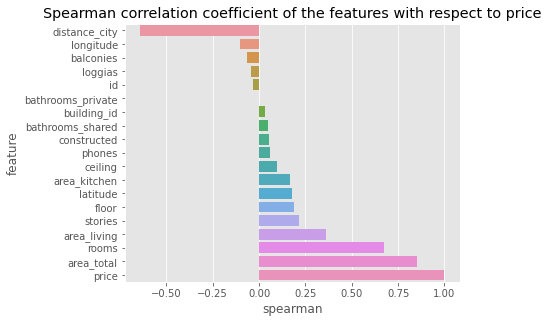

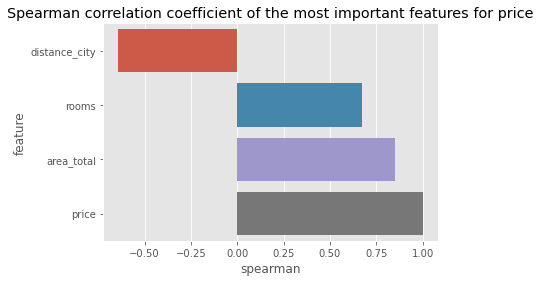

In [32]:
numerical.append('distance_city')
spearman(all_data, numerical)

Now, we can see that the distance to the city centre is indeed well correlated with the sale price of the house. The negative sign indicates that when one variable increases the other decreases. This is logical because as the distance of the house from the city centre increases, the price decreases. 

#### 3- Distance to famous places

We also added the distance between the flats and the most famous places in Moscow such as Kremlin, Gorgy park... or also the nearest metro station, which is supposed to have a great influence on the price. 

In [34]:
def distance(loc1,loc2) :
    return hs.haversine(loc1,loc2)

#Distance to Kremlin
kremlin = [55.752121, 37.617664]
dist_kremlin = []

for i in range(len(all_data)) :
    coord = [all_data.latitude[i], all_data.longitude[i]]
    dist_kremlin.append(distance(kremlin, coord))
    
all_data = all_data.assign(dist_kremlin = dist_kremlin)

# Distance to Gorky park
gorky = [55.7255, 37.6023]
dist_gorky = []

for i in range(len(all_data)) :
    coord = [all_data.latitude[i], all_data.longitude[i]]
    dist_gorky.append(distance(gorky, coord))
    
all_data = all_data.assign(dist_gorky = dist_gorky)

# Distance to Kolomenskoye
kolo = [55.669444, 37.668889]
dist_kolo = []

for i in range(len(all_data)) :
    coord = [all_data.latitude[i], all_data.longitude[i]]
    dist_kolo.append(distance(kolo, coord))
    
all_data = all_data.assign(dist_kolo = dist_kolo)

# Distance to Moscow Metro
met = [55.6497, 37.3911]
dist_met = []

for i in range(len(all_data)) :
    coord = [all_data.latitude[i], all_data.longitude[i]]
    dist_met.append(distance(met, coord))
    
all_data = all_data.assign(dist_met = dist_met)

We now make a new feature with the shortest distance to a station. The data of stations in Moscow is taken from: https://github.com/theptyza/map_moscow_metro_foursquare/blob/master/stations_venues_1000.csv. 

In [36]:
# Shortest distance to a metro station
stations = pd.read_csv('stations.csv')

min_dist_metro = []

for i in range(len(all_data)):
    dist_metro = []
    lat1 = all_data.latitude[i]
    lon1 = all_data.longitude[i]
    loc1 = lat1,lon1

    for coor in stations.Coordinates:
        coordinates = coor.split(',')
        lat2 = float(coordinates[0])
        lon2 = float(coordinates[1])
        loc2 = lat2,lon2
        dist_metro.append(hs.haversine(loc1,loc2))
    
    dist_metro.sort()
    min = dist_metro[0]
    min_dist_metro.append(min)

all_data = all_data.assign(min_dist_metro = min_dist_metro )

Then we have to encode the categorical values. We tried 2 different methods such as *OneHotEncoder* and the second one *TargetEncoder*. The *TargetEncoder* gives us the best results. 

In [37]:
#Encode 
cat_to_encod = ['seller', 'layout', 'condition', 'district', 'material', 'parking', 'heating']

#Method 1 
"""
enc = OneHotEncoder(categories='auto')
for feature in cat_to_encod: 
    all_data[feature]=imputer.fit_transform(all_data[feature].values.reshape(-1,1))[:,0]
    all_data[feature]=pd.DataFrame(enc.fit_transform(all_data[[feature]]).toarray())
"""

#Method 2 
enc = ce.TargetEncoder()
all_data['district']
y = all_data['price']
enc = ce.TargetEncoder(cols=cat_to_encod).fit(all_data, y)
numeric_dataset = enc.transform(all_data)
numeric_dataset['district']

0        7.343933e+06
1        1.293236e+07
2        1.658807e+07
3        1.293236e+07
4        7.343933e+06
             ...     
33217    1.974773e+07
33218    3.953265e+07
33219    3.953265e+07
33220    1.335469e+07
33221    5.706130e+06
Name: district, Length: 33222, dtype: float64

Now that we have made all the necessary changes to the data, we can return to *data_train* and *data_test*. Moreover, we remove the duplicates in *data_train*.

In [38]:
data_train = all_data[:N_train]
data_test = all_data[N_train:]

data_train = data_train.drop("id", axis=1)
data_test = data_test.drop("id", axis=1)
data_test = data_test.drop("price", axis=1)

data_train = data_train.drop(data_train[data_train.duplicated()].index, axis=0)
#don't drop over data_test otherwise at the end we won't have the good size 
len(data_train[data_train.duplicated()])

0

Based on the EDA we are making the following features.

In [39]:
#log1(area_total)
data_train = data_train.assign(log_area_total = np.log1p(data_train.area_total)) 
data_test = data_test.assign(log_area_total = np.log1p(data_test.area_total)) 

#total number of bathrooms
data_train = data_train.assign(tot_bathrooms = data_train.bathrooms_shared + data_train.bathrooms_private)
data_test = data_test.assign(tot_bathrooms = data_test.bathrooms_shared + data_test.bathrooms_private)

#log(area_total)/rooms
data_train = data_train.assign(logarea_per_room = np.log1p(data_train.area_total)/data_train.rooms)
data_test = data_test.assign(logarea_per_room = np.log1p(data_test.area_total)/data_test.rooms)

#stories**2/(nb elevators)
data_train = data_train.assign(sqStories_per_nb_elevators = data_train.stories**2/(data_train.elevator_passenger+data_train.elevator_without+data_train.elevator_service)) 
data_test = data_test.assign(sqStories_per_nb_elevators = data_test.stories**2/(data_test.elevator_passenger+data_test.elevator_without+data_test.elevator_service)) 

#balconies + loggias
data_train = data_train.assign(fancy_stuff = data_train.balconies + data_train.loggias) 
data_test = data_test.assign(fancy_stuff = data_test.balconies + data_test.loggias) 

#total number of windows
data_train = data_train.assign(tot_windows = data_train.windows_court + data_train.windows_street) 
data_test = data_test.assign(tot_windows = data_test.windows_court + data_test.windows_street) 

data_train = data_train.drop(['seller', 'windows_court', 'windows_street', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'garbage_chute', 'street', 'address', 'building_id', 'longitude', 'latitude', 'balconies', 'loggias', 'bathrooms_shared', 'bathrooms_private'], axis=1)
data_test = data_test.drop(['seller', 'windows_court', 'windows_street', 'new', 'elevator_without', 'elevator_passenger', 'elevator_service', 'garbage_chute', 'street', 'address', 'building_id', 'longitude', 'latitude', 'balconies', 'loggias', 'bathrooms_shared', 'bathrooms_private'], axis=1)

data_train.columns

Index(['price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms',
       'layout', 'ceiling', 'condition', 'phones', 'district', 'constructed',
       'material', 'stories', 'parking', 'heating', 'area_ratio',
       'floor_ratio', 'distance_city', 'dist_kremlin', 'dist_gorky',
       'dist_kolo', 'dist_met', 'min_dist_metro', 'log_area_total',
       'tot_bathrooms', 'logarea_per_room', 'sqStories_per_nb_elevators',
       'fancy_stuff', 'tot_windows'],
      dtype='object')

# Part.2 : Model

In [40]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#!pip install lightgbm
#!pip install catboost
#!pip install xgboost
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, RidgeCV, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb

## Metric : RMSLE 

In [41]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [42]:
data_train

price  area_total  area_kitchen  area_living  floor  rooms  \
0       7139520.0        59.2          12.5         31.0    2.0    2.0   
1      10500000.0        88.0          14.2         48.0   18.0    3.0   
2       9019650.0        78.5          22.5         40.8   12.0    3.0   
3      10500000.0        88.0          14.0         48.0   18.0    3.0   
4      13900000.0        78.0          17.0         35.0    7.0    2.0   
...           ...         ...           ...          ...    ...    ...   
23280  13300000.0        65.0          16.0         32.0    3.0    2.0   
23281  15854300.0        56.9           9.6         36.5    6.0    2.0   
23282  19800000.0        73.4          23.0         29.3   16.0    2.0   
23283  29999000.0       100.8          20.0       -999.0    4.0    3.0   
23284  10950000.0        57.7           8.4       -999.0    4.0    2.0   

       layout  ceiling  condition  phones  ...  dist_gorky  dist_kolo  \
0         1.0     2.65        1.0     1.0  ...   21.631383  18.387469   
1         1.0  -999.00        3.0     1.0  ...   15.624924  21.331903   
2         1.0     2.65        1.0     1.0  ...    8.805738   9.654383   
3         1.0  -999.00        2.0     1.0  ...   15.624924  21.331903   
4         1.0     2.90        3.0     1.0  ...   17.718468  16.211927   
...       ...      ...        ...     ...  ...         ...        ...   
23280     1.0     3.00        3.0     1.0  ...   14.994028  21.494138   
23281     1.0  -999.00        1.0     1.0  ...    6.781652  13.942979   
23282     1.0  -999.00        1.0     0.0  ...    6.400844  13.525261   
23283     1.0  -999.00        1.0     0.0  ...   14.011516   6.697219   
23284     1.0  -999.00        1.0     0.0  ...    1.938936   5.704633   

        dist_met  min_dist_metro  log_area_total  tot_bathrooms  \
0      12.956293        2.468090        4.097672            2.0   
1      29.168209        0.913505        4.488636            2.0   
2       7.938735        1.642464        4.375757            2.0   
3      29.168209        0.913505        4.488636            2.0   
4       7.567669        3.945127        4.369448            1.0   
...          ...             ...             ...            ...   
23280  13.493443        2.515223        4.189655            1.0   
23281  19.433036        0.788227        4.058717        -1998.0   
23282  13.862681        0.862510        4.309456        -1998.0   
23283  19.655242        0.240643        4.623010        -1998.0   
23284  15.216724        0.798664        4.072440        -1998.0   

       logarea_per_room  sqStories_per_nb_elevators  fancy_stuff  tot_windows  
0              2.048836                   40.500000      -1998.0          1.0  
1              1.496212                  312.500000          1.0          2.0  
2              1.458586                  112.500000      -1998.0          2.0  
3              1.496212                  312.500000          1.0          2.0  
4              2.184724                  112.500000          1.0          2.0  
...                 ...                         ...          ...          ...  
23280          2.094827                  288.000000          1.0          1.0  
23281          2.029359                  400.000000      -1998.0          1.0  
23282          2.154728                   85.333333      -1998.0          1.0  
23283          1.541003                   50.000000      -1998.0          1.0  
23284          2.036220                   12.500000      -1998.0          1.0  

[22797 rows x 30 columns]

In [43]:
data_test

area_total  area_kitchen  area_living  floor  rooms  layout  \
23285        71.4        -999.0       -999.0    2.0    1.0     1.0   
23286        54.0           4.0         50.0    4.0    1.0     1.0   
23287        39.4          19.6         11.2   10.0    1.0     1.0   
23288        60.9        -999.0       -999.0    5.0    2.0     1.0   
23289        34.0           9.0         17.0   14.0    1.0     1.0   
...           ...           ...          ...    ...    ...     ...   
33217       106.0          19.9         56.7   16.0    3.0     1.0   
33218        82.0        -999.0       -999.0    3.0    3.0     1.0   
33219        49.3        -999.0       -999.0   15.0    1.0     1.0   
33220        38.8          10.5         15.1   14.0    1.0     1.0   
33221        71.5           7.0         49.0    2.0    3.0     1.0   

          ceiling  condition  phones  district  ...  dist_gorky  dist_kolo  \
23285 -999.000000        0.0     1.0       0.0  ...    5.273419  12.760853   
23286    3.000000        3.0     1.0      11.0  ...   17.613689  16.106819   
23287    2.650000        1.0     1.0      11.0  ...   16.892374  17.040730   
23288 -999.000000        0.0     1.0      11.0  ...   19.026019  16.309999   
23289    2.750000        1.0     1.0      11.0  ...   28.204875  26.468184   
...           ...        ...     ...       ...  ...         ...        ...   
33217    3.300000        1.0     1.0       8.0  ...   11.588705  18.864211   
33218 -999.000000        1.0     2.0       7.0  ...    6.120256  13.226984   
33219    2.859103        1.0     1.0       7.0  ...   15.071833  21.561715   
33220    3.300000        0.0     2.0       5.0  ...    3.584770   3.930828   
33221 -999.000000        1.0     0.0      10.0  ...   31.914176  30.735864   

        dist_met  min_dist_metro  log_area_total  tot_bathrooms  \
23285  15.954061        0.825810        4.282206        -1998.0   
23286   7.540850        3.911508        4.007333        -1998.0   
23287   3.901647        0.903399        3.698830            1.0   
23288  10.547590        4.139059        4.125520            1.0   
23289  14.938229       11.048493        3.555348            1.0   
...          ...             ...             ...            ...   
33217  16.102016        2.149622        4.672829        -1998.0   
33218  13.783701        0.631968        4.418841            2.0   
33219  13.486720        2.576172        3.918005        -1998.0   
33220  16.410088        0.720180        3.683867            1.0   
33221  17.546651       14.673673        4.283587        -1998.0   

       logarea_per_room  sqStories_per_nb_elevators  fancy_stuff  tot_windows  
23285          4.282206                  133.333333          1.0          1.0  
23286          4.007333                  112.500000      -1998.0          1.0  
23287          3.698830                   40.500000      -1998.0          1.0  
23288          2.062760                  144.500000      -1998.0          1.0  
23289          3.555348                  144.500000          1.0          1.0  
...                 ...                         ...          ...          ...  
33217          1.557610                  200.000000          1.0          1.0  
33218          1.472947                  200.000000      -1998.0          1.0  
33219          3.918005                  288.000000      -1998.0          1.0  
33220          3.683867                   65.333333          1.0          1.0  
33221          1.427862                    2.000000      -1998.0          1.0  

[9937 rows x 29 columns]

## Choice of parameters *learning_rate*, *n_estimators*, *n_iterations* 

To avoid overfitting we must pay attention to certain parameters in particular *learning_rate*, *n_estimators*, *n_iterations*. Then for each model we will use in the end, we plot the values of Valid_RMSLE and Train_RMSLE and see when the valid plot starts to increase again and which is also the point where the distance between the 2 plots start to be too large. 

Here we gave an example of implementation for LGBM :

In [47]:
interval = [10,100,1000,2000,3000]
valid_plot = []
train_plot = []
SEED = 42

metamodel_level1=RidgeCV()
y_train = data_train.price
x_train = data_train.drop("price", axis=1)

x_train = x_train.values
y_train = y_train.values
data_test = data_test.values

for i in interval :
    
    print("i :", i)
    
    lgbm= LGBMRegressor(
    objective="regression",
    num_leaves=32,
    max_depth=5,
    random_state=SEED,
    metric='mse',
    n_jobs=2,
    n_estimators=i,
    colsample_bytree=0.7,
    subsample=0.7,
    verbose=-1
    )
    
    estimators_level0 =[
    #('random_forest', rf),
    ('lgbm',lgbm),
    #('catboost',cb),
    ]

    reg=StackingRegressor(estimators=estimators_level0,n_jobs=-2,final_estimator=metamodel_level1,cv=5,verbose=-1)
    #reg=StackingRegressor(estimators=estimators_level0,final_estimator=metamodel_level1,cv=5)

    Valid_RMSE = []
    Train_RMSE = []
    predictions = []
    kf=KFold(random_state=0,shuffle=True)

    for train_index, test_index in kf.split(x_train):
        print("TRAIN : ",train_index, "TEST : ", test_index)
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        reg.fit(x_train_fold,np.log(y_train_fold))
        pred_train = np.exp(reg.predict(x_train_fold))
        pred_valid = np.exp(reg.predict(x_test_fold))
        Valid_RMSE.append(root_mean_squared_log_error(y_test_fold,pred_valid))
        Train_RMSE.append(root_mean_squared_log_error(y_train_fold,pred_train))
        predictions.append(np.exp(reg.predict(data_test)))
        print("Valid_RMSE: ", Valid_RMSE)
    
    print("Mean RMSE ", np.mean(Valid_RMSE))
    valid_plot.append(np.mean(Valid_RMSE))
    train_plot.append(np.mean(Train_RMSE))
    print(valid_plot)
    print(train_plot)

i : 10
TRAIN :  [    0     1     2 ... 22790 22791 22794] TEST :  [    7    12    16 ... 22793 22795 22796]
Valid_RMSE:  [0.257703829567695]
TRAIN :  [    0     2     3 ... 22793 22795 22796] TEST :  [    1     4     8 ... 22764 22777 22794]
Valid_RMSE:  [0.257703829567695, 0.23871016288294936]
TRAIN :  [    1     4     7 ... 22794 22795 22796] TEST :  [    0     2     3 ... 22779 22780 22781]
Valid_RMSE:  [0.257703829567695, 0.23871016288294936, 0.2388194296196683]
TRAIN :  [    0     1     2 ... 22794 22795 22796] TEST :  [   11    15    21 ... 22778 22787 22791]
Valid_RMSE:  [0.257703829567695, 0.23871016288294936, 0.2388194296196683, 0.2566567977869192]
TRAIN :  [    0     1     2 ... 22794 22795 22796] TEST :  [   10    13    19 ... 22776 22789 22790]
Valid_RMSE:  [0.257703829567695, 0.23871016288294936, 0.2388194296196683, 0.2566567977869192, 0.26111057490428524]
Mean RMSE  0.2506001589523034
[0.2506001589523034]
[0.24312442727765077]
i : 100
TRAIN :  [    0     1     2 ... 22790

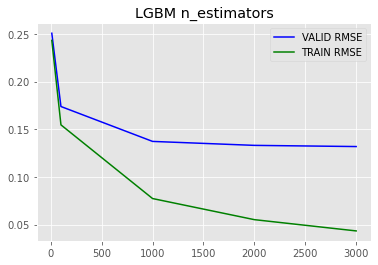

In [48]:
#PLOT
x = interval
y1 = valid_plot
y2 = train_plot
plt.plot(x, y1, label = "VALID RMSE", c="blue")
plt.plot(x, y2, label = "TRAIN RMSE", c="green")
#plt.axvline(x=200)
plt.legend()
plt.title('LGBM n_estimators')
plt.show() 

## FINAL MODEL

In [49]:
SEED = 0 

#Some models
rf=RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=SEED,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

ada = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='square',
    random_state=SEED
)

lgbm= LGBMRegressor(
    objective="regression",
    num_leaves=32,
    max_depth=5,
    random_state=SEED,
    learning_rate=0.12, 
    metric='mse',
    n_jobs=2,
    n_estimators=2000,
    colsample_bytree=0.7,
    subsample=0.7,
    verbose=-1
)

#2nd model with lgbm with different values for learning_rate and n_estimators 
lgbm2= LGBMRegressor(
    objective="regression",
    num_leaves=32,
    max_depth=5,
    random_state=SEED,
    learning_rate=0.15, 
    metric='mse',
    n_jobs=2,
    n_estimators=3000,
    colsample_bytree=0.7,
    subsample=0.7,
    verbose=-1
)

cb= CatBoostRegressor(
    iterations=2000,
    depth=7,
    learning_rate=0.3, 
    l2_leaf_reg=0.45,
    silent=True,
    random_seed=0
)

xgb= XGBRegressor(
    n_estimators=1500,
    max_depth=5,
    n_jobs=-2,
    booster='gbtree',
    enable_categorical=True,
    colsample_bytree=0.7,
    subsample=0.7,
    learning_rate=0.1,
    random_state=42069
)

### a) Method 1 : Simple average 

This will not be our final model since stacking gives us better results. 

In [ ]:
"""X_train, x_valid = model_selection.train_test_split(data_train, test_size=0.33, stratify=np.log(data_train.price).round())
y_train = np.log(X_train.price)
y_valid = np.log(x_valid.price)

y_train = data_train.price
x_train = data_train.drop("price", axis=1)

x_train = x_train.values
y_train = y_train.values
data_test = data_test.values

rf.fit(x_train,np.log(y_train))
pred_rfV=np.exp(rf.predict(x_valid))
pred_rfT=np.exp(rf.predict(x_train))

lgbm.fit(x_train,np.log(y_train))
pred_lgbmV=np.exp(lgbm.predict(x_valid))
pred_lgbmT=np.exp(lgbm.predict(x_train))

cb.fit(x_train,np.log(y_train))
pred_cbV=np.exp(cb.predict(x_valid))
pred_cbT=np.exp(cb.predict(x_train))

avg_prediction1 = np.mean([pred_rfV, pred_lgbmV, pred_cbV], axis=0)
avg_prediction2 = np.mean([pred_rfT, pred_lgbmT, pred_cbT], axis=0)

#Simple average
Valid_RMSE = (root_mean_squared_log_error(y_valid,avg_prediction1))
Train_RMSE = (root_mean_squared_log_error(y_train,avg_prediction2))

pred_rf_test=np.exp(rf.predict(data_test))
pred_lgbm_test=np.exp(lgbm.predict(data_test))
pred_cb_test=np.exp(cb.predict(data_test))

final_predictions = np.mean([pred_rf_test, pred_lgbm_test, pred_cb_test], axis=0)

print("Valid_RMSE: ", Valid_RMSE)"""

### b) Method 2 : Stacking 


In [51]:
"""y_train = data_train.price
x_train = data_train.drop("price", axis=1)

x_train = x_train.values
y_train = y_train.values
data_test = data_test.values
"""
metamodel_level1=RidgeCV()

estimators_level0 =[
    ('random_forest', rf),
    ('lgbm',lgbm),
    ('catboost',cb),
]

reg=StackingRegressor(estimators=estimators_level0,n_jobs=-2,final_estimator=metamodel_level1,cv=5,verbose=-1)

Valid_RMSE = []
predictions = []
kf=KFold(random_state=0,shuffle=True)

for train_index, test_index in kf.split(x_train):
    print("TRAIN : ",train_index, "TEST : ", test_index)
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    reg.fit(x_train_fold,np.log(y_train_fold))
    pred_valid =np.exp(reg.predict(x_test_fold))
    Valid_RMSE.append(root_mean_squared_log_error(y_test_fold,pred_valid))
    predictions.append(np.exp(reg.predict(data_test)))
    print("Valid_RMSE: ", Valid_RMSE)
    
print("Mean RMSE ", np.mean(Valid_RMSE))

## 0.1275

TRAIN :  [    0     1     2 ... 22790 22791 22794] TEST :  [    7    12    16 ... 22793 22795 22796]
Valid_RMSE:  [0.12973921826918416]
TRAIN :  [    0     2     3 ... 22793 22795 22796] TEST :  [    1     4     8 ... 22764 22777 22794]
Valid_RMSE:  [0.12973921826918416, 0.12433117818543894]
TRAIN :  [    1     4     7 ... 22794 22795 22796] TEST :  [    0     2     3 ... 22779 22780 22781]
Valid_RMSE:  [0.12973921826918416, 0.12433117818543894, 0.11792911003560909]
TRAIN :  [    0     1     2 ... 22794 22795 22796] TEST :  [   11    15    21 ... 22778 22787 22791]
Valid_RMSE:  [0.12973921826918416, 0.12433117818543894, 0.11792911003560909, 0.12706469932452233]
TRAIN :  [    0     1     2 ... 22794 22795 22796] TEST :  [   10    13    19 ... 22776 22789 22790]
Valid_RMSE:  [0.12973921826918416, 0.12433117818543894, 0.11792911003560909, 0.12706469932452233, 0.13570071012367022]
Mean RMSE  0.12695298318768494


## Model interpretation : Feature importance 

In [56]:
print(data_train.columns)

Index(['price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms',
       'layout', 'ceiling', 'condition', 'phones', 'district', 'constructed',
       'material', 'stories', 'parking', 'heating', 'area_ratio',
       'floor_ratio', 'distance_city', 'dist_kremlin', 'dist_gorky',
       'dist_kolo', 'dist_met', 'min_dist_metro', 'log_area_total',
       'tot_bathrooms', 'logarea_per_room', 'sqStories_per_nb_elevators',
       'fancy_stuff', 'tot_windows'],
      dtype='object')


In [57]:
rf.fit(x_train, y_train)
lgbm.fit(x_train,y_train)
cb.fit(x_train,y_train)

features=['area_total','area_kitchen','area_living','floor','rooms','layout','ceiling','condition','phones','district','constructed','material','stories','parking','heating','area_ratio','floor_ratio','distance_city','dist_kremlin', 'dist_gorky', 'dist_kolo', 'dist_met', 'min_dist_metro', 'log_area_total','tot_bathrooms','logarea_per_room','sqStories_per_nb_elevators','fancy_stuff','tot_windows'] 
fig = px.bar(x=features, y = rf.feature_importances_,title="feature importances of RandomForest")
fig.update_xaxes(type='category')
fig.show()

fig = px.bar(x=features, y = lgbm.feature_importances_,title="feature importances of LGBM")
fig.update_xaxes(type='category')
fig.show()

fig = px.bar(x=features, y = cb.feature_importances_,title="feature importances of CatBoost")
fig.update_xaxes(type='category')
fig.show()

For the Random Forest, `area_total` and `log_area_total` are the most important features compared to the others that seems to be useless. However the other features are relevant for LGBM and CatBoost. We can notice that for LGBM, half of the features have almost the same importance.    

# Sample submission

Finally we make the predictions for the test data and submit the predictions on kaggle.

In [53]:
print(predictions)
final_predictions=np.mean(predictions,axis=0)
print(final_predictions)
aux = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

# Construct submission dataframe
submission=pd.DataFrame()
submission['id']=aux.id
submission["price_prediction"]=final_predictions
print(f'Generated {len(submission)} predictions')
submission.to_csv('sample_submission.csv',index=False)

[array([31045184.47595778, 10262887.77296068,  6458542.90736986, ...,
        8861244.08540607,  8835488.88679514,  6262373.17694207]), array([28537080.33809099,  9913470.76860928,  6373196.99536293, ...,
        9083299.05737741,  9462227.01932735,  4921780.73778577]), array([28482357.16709761,  9672197.27998752,  6275970.21240781, ...,
        9385587.97493584,  9135610.4280721 ,  6090241.12254967]), array([29644853.95530535, 10040814.95291797,  6277776.15415262, ...,
        9065603.00411974,  9256054.35554259,  5885470.3721513 ]), array([27643454.90303867,  8797591.42027407,  6328207.66314647, ...,
        8735598.94733153,  9398603.33543607,  5564828.98656099])]
[29070586.16789808  9737392.4389499   6342738.78648794 ...
  9026266.61383412  9217596.80503465  5744938.87919796]
Generated 9937 predictions
